In [1]:
import rlcard
from rlcard.envs.registration import register
from rlcard.utils import get_device, Logger, reorganize, plot_curve
from rlcard.agents import RandomAgent

from rlcard.agents import DQNAgent
from pseudo_optimal import PseudoOptimalAgent
import torch
import numpy as np
import argparse
import os
from copy import deepcopy
from tqdm import tqdm




In [2]:

register(
    env_id='yaniv',
    entry_point='env:YanivEnv',
)
rlcard.make('yaniv', config={'game_num_players': 4})
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [3]:
baseline_env = rlcard.make('yaniv')
baseline_agents = [PseudoOptimalAgent(num_actions=baseline_env.num_actions)] + [RandomAgent(num_actions=baseline_env.num_actions) for _ in range(baseline_env.num_players - 1)]
baseline_env.set_agents(baseline_agents)

In [4]:
def tournament(env, num):
    payoffs = [0 for _ in range(env.num_players)]
    running_turns = 0
    counter = 0
    win_rates = [0 for _ in range(env.num_players)]
    
    while counter < num:
        _, _payoffs = env.run(is_training=False)
        running_turns += len(env.action_recorder) / env.num_players
        for i in range(len(_payoffs)):
            payoffs[i] += _payoffs[i]
        winner = np.argmax(_payoffs)
        win_rates[winner] += 1
        counter += 1
    for i, _ in enumerate(payoffs):
        payoffs[i] /= counter
        win_rates[i] /= counter
    return payoffs, win_rates, running_turns / counter

In [5]:
payoffs, win_rates, mean_turns = tournament(baseline_env, 100)
print(payoffs, win_rates, mean_turns)

[23.933333333333334, -9.653333333333334, -8.186666666666666, -6.093333333333331] [0.92, 0.01, 0.02, 0.05] 6.7975


In [6]:
baseline_agents = [PseudoOptimalAgent(num_actions=baseline_env.num_actions), PseudoOptimalAgent(num_actions=baseline_env.num_actions), PseudoOptimalAgent(num_actions=baseline_env.num_actions), RandomAgent(num_actions=baseline_env.num_actions)]
baseline_env.set_agents(baseline_agents)
payoffs, win_rates, mean_turns = tournament(baseline_env, 100)
print(payoffs, win_rates, mean_turns)

[6.826666666666669, 4.453333333333332, 5.960000000000003, -17.24] [0.42, 0.29, 0.29, 0.0] 5.265


In [7]:
baseline_agents = [PseudoOptimalAgent(num_actions=baseline_env.num_actions), PseudoOptimalAgent(num_actions=baseline_env.num_actions), PseudoOptimalAgent(num_actions=baseline_env.num_actions), PseudoOptimalAgent(num_actions=baseline_env.num_actions)]
baseline_env.set_agents(baseline_agents)
payoffs, win_rates, mean_turns = tournament(baseline_env, 100)
print(payoffs, win_rates, mean_turns)

[0.7866666666666664, -1.759999999999999, 0.5466666666666666, 0.4266666666666666] [0.31, 0.19, 0.23, 0.27] 4.885


In [8]:
baseline_agents = [RandomAgent(num_actions=baseline_env.num_actions) for _ in range(baseline_env.num_players)]
baseline_env.set_agents(baseline_agents)
payoffs, win_rates, mean_turns = tournament(baseline_env, 100)
print(payoffs, win_rates, mean_turns)

[-0.7066666666666663, 0.14666666666666722, -0.5199999999999997, 1.08] [0.22, 0.23, 0.23, 0.32] 16.5875


In [9]:

env = rlcard.make('yaniv')


agent = DQNAgent(
                replay_memory_size=100000,
                num_actions=env.num_actions,
                state_shape=env.state_shape[0],
                mlp_layers=[64, 64],
                device=device, 
                discount_factor=0.99,
                batch_size=32,
                train_every=1, 
                update_target_estimator_every=30000,
                epsilon_decay_steps=7500000,
                epsilon_end=0.05,
                learning_rate=0.000005
            )

env.set_agents([agent, agent, agent, agent])


In [10]:
NUM_EPISODES = 200000
EVAL_EVERY = 5000
BASELINE_EVAL_GAMES = 1000

In [11]:
eval_env = rlcard.make('yaniv')

selfplay_scores = []
selfplay_turns = []

baseline_win_rates = []
baseline_scores = []
baseline_opp_scores = []
baseline_turns = []

optimal_win_rates = []
optimal_scores = []
optimal_opp_scores = []
optimal_turns = []

for episode in range(NUM_EPISODES):
    trajectories, payoffs = env.run(is_training=True)
    trajectories = reorganize(trajectories, payoffs)
    for trajectory in trajectories:
        for ts in trajectory:
            env.agents[0].feed(ts)
    
    if episode % EVAL_EVERY == 0:
        cur_agent = env.agents[0]
        eval_env.set_agents([cur_agent] + [PseudoOptimalAgent(num_actions=eval_env.num_actions) for _ in range(eval_env.num_players - 1)])
        payoffs, win_rates, mean_turns = tournament(eval_env, BASELINE_EVAL_GAMES)
        optimal_scores.append(payoffs[0])
        optimal_opp_scores.append(sum(payoffs[1:])/len(payoffs[1:]))
        optimal_turns.append(mean_turns)
        optimal_win_rates.append(win_rates[0])

        print(f'episode {episode} DQN Agent vs. Psuedo-Optimal Mean Score: {optimal_scores[-1]}')
        print(f'episode {episode} Psuedo-Optimal vs. DQN Agent Mean Score: {optimal_opp_scores[-1]}')
        print(f'episode {episode} DQN Agent vs. Psuedo-Optimal Mean Turns: {optimal_turns[-1]}')
        print(f'episode {episode} DQN Agent vs. Psuedo-Optimal Win Rate: {optimal_win_rates[-1]}')

        eval_env.set_agents([cur_agent] + [RandomAgent(num_actions=eval_env.num_actions) for _ in range(eval_env.num_players - 1)])
        payoffs, win_rates, mean_turns = tournament(eval_env, BASELINE_EVAL_GAMES)
        baseline_scores.append(payoffs[0])
        baseline_opp_scores.append(sum(payoffs[1:])/len(payoffs[1:]))
        baseline_turns.append(mean_turns)
        baseline_win_rates.append(win_rates[0])

        print(f'episode {episode} DQN Agent vs. Random Mean Score: {baseline_scores[-1]}')
        print(f'episode {episode} Random vs. DQN Agent Mean Score: {baseline_opp_scores[-1]}')
        print(f'episode {episode} DQN Agent vs. Random Mean Turns: {baseline_turns[-1]}')
        print(f'episode {episode} DQN Agent vs. Random Win Rate: {baseline_win_rates[-1]}')
        print(f'Training steps: {env.timestep}')
        


episode 0 DQN Agent vs. Psuedo-Optimal Mean Score: -19.294999999999973
episode 0 Psuedo-Optimal vs. DQN Agent Mean Score: 6.431666666666672
episode 0 DQN Agent vs. Psuedo-Optimal Mean Turns: 5.356
episode 0 DQN Agent vs. Psuedo-Optimal Win Rate: 0.007
episode 0 DQN Agent vs. Random Mean Score: -3.007000000000003
episode 0 Random vs. DQN Agent Mean Score: 1.0023333333333329
episode 0 DQN Agent vs. Random Mean Turns: 15.857
episode 0 DQN Agent vs. Random Win Rate: 0.223
Training steps: 29


/Users/marshingjay/mambaforge/envs/python38/lib/python3.8/site-packages/rlcard/agents/dqn_agent.py:194: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  state_batch, action_batch, reward_batch, next_state_batch, legal_actions_batch, done_batch = self.memory.sample()


episode 5000 DQN Agent vs. Psuedo-Optimal Mean Score: -6.14533333333333
episode 5000 Psuedo-Optimal vs. DQN Agent Mean Score: 2.0484444444444443
episode 5000 DQN Agent vs. Psuedo-Optimal Mean Turns: 5.364
episode 5000 DQN Agent vs. Psuedo-Optimal Win Rate: 0.072
episode 5000 DQN Agent vs. Random Mean Score: 9.460333333333333
episode 5000 Random vs. DQN Agent Mean Score: -3.1534444444444425
episode 5000 DQN Agent vs. Random Mean Turns: 13.6055
episode 5000 DQN Agent vs. Random Win Rate: 0.508
Training steps: 313963
episode 10000 DQN Agent vs. Psuedo-Optimal Mean Score: -5.1393333333333375
episode 10000 Psuedo-Optimal vs. DQN Agent Mean Score: 1.7131111111111117
episode 10000 DQN Agent vs. Psuedo-Optimal Mean Turns: 5.35675
episode 10000 DQN Agent vs. Psuedo-Optimal Win Rate: 0.102
episode 10000 DQN Agent vs. Random Mean Score: 14.405000000000022
episode 10000 Random vs. DQN Agent Mean Score: -4.801666666666661
episode 10000 DQN Agent vs. Random Mean Turns: 12.289
episode 10000 DQN Agent

KeyboardInterrupt: 

In [15]:

payoffs, win_rates, mean_turns = tournament(env, BASELINE_EVAL_GAMES)
print(payoffs, win_rates, mean_turns)

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 810])

In [ ]:
# save the model
save_path = os.path.join('./', 'model2.pth')
torch.save(env.agents[0], save_path)
print('Model saved in', save_path)

Model saved in ./model.pth


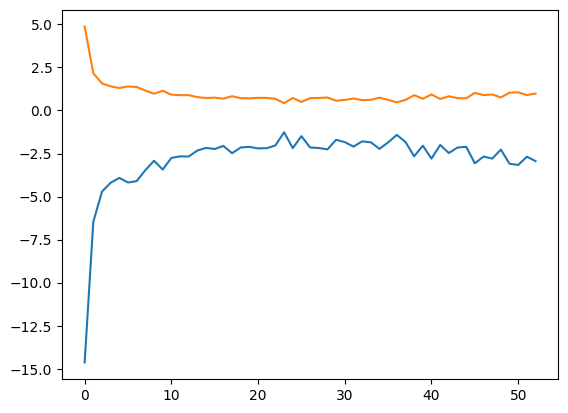

In [ ]:
import matplotlib.pyplot as plt

plt.plot(optimal_scores, label='DQN vs. Pseudo-Optimal')
plt.plot(optimal_opp_scores, label='Pseudo-Optimal vs. DQN')

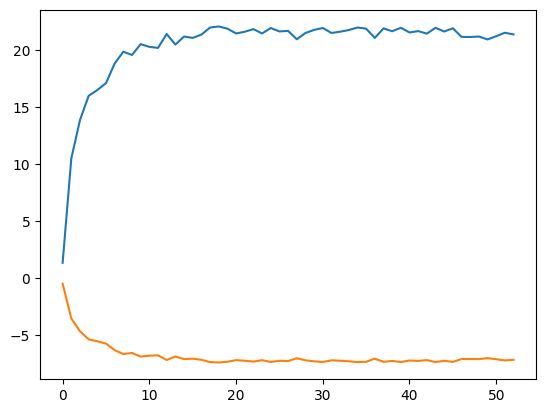

In [ ]:
plt.plot(baseline_scores, label='DQN vs. Random')
plt.plot(baseline_opp_scores, label='Random vs. DQN')

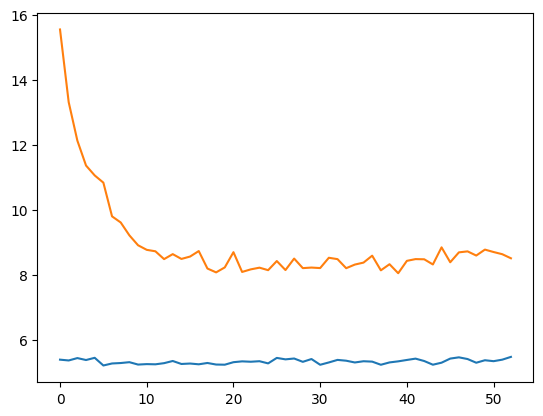

In [ ]:
plt.plot(optimal_turns, label='DQN vs. Pseudo-Optimal Turns')
plt.plot(baseline_turns, label='DQN vs. Random Turns')

In [ ]:
for episode in range(NUM_EPISODES, NUM_EPISODES*2):
    trajectories, payoffs = env.run(is_training=True)
    trajectories = reorganize(trajectories, payoffs)
    for trajectory in trajectories:
        for ts in trajectory:
            env.agents[0].feed(ts)
    
    if episode % EVAL_EVERY == 0:
        cur_agent = env.agents[0]
        eval_env.set_agents([cur_agent] + [PseudoOptimalAgent(num_actions=eval_env.num_actions) for _ in range(eval_env.num_players - 1)])
        payoffs, win_rates, mean_turns = tournament(eval_env, BASELINE_EVAL_GAMES)
        optimal_scores.append(payoffs[0])
        optimal_opp_scores.append(sum(payoffs[1:])/len(payoffs[1:]))
        optimal_turns.append(mean_turns)
        optimal_win_rates.append(win_rates[0])

        print(f'episode {episode} DQN Agent vs. Psuedo-Optimal Mean Score: {optimal_scores[-1]}')
        print(f'episode {episode} Psuedo-Optimal vs. DQN Agent Mean Score: {optimal_opp_scores[-1]}')
        print(f'episode {episode} DQN Agent vs. Psuedo-Optimal Mean Turns: {optimal_turns[-1]}')
        print(f'episode {episode} DQN Agent vs. Psuedo-Optimal Win Rate: {optimal_win_rates[-1]}')

        eval_env.set_agents([cur_agent] + [RandomAgent(num_actions=eval_env.num_actions) for _ in range(eval_env.num_players - 1)])
        payoffs, win_rates, mean_turns = tournament(eval_env, BASELINE_EVAL_GAMES)
        baseline_scores.append(payoffs[0])
        baseline_opp_scores.append(sum(payoffs[1:])/len(payoffs[1:]))
        baseline_turns.append(mean_turns)
        baseline_win_rates.append(win_rates[0])

        print(f'episode {episode} DQN Agent vs. Random Mean Score: {baseline_scores[-1]}')
        print(f'episode {episode} Random vs. DQN Agent Mean Score: {baseline_opp_scores[-1]}')
        print(f'episode {episode} DQN Agent vs. Random Mean Turns: {baseline_turns[-1]}')
        print(f'episode {episode} DQN Agent vs. Random Win Rate: {baseline_win_rates[-1]}')
        print(f'Training steps: {env.timestep}')
        

/Users/marshingjay/mambaforge/envs/python38/lib/python3.8/site-packages/rlcard/agents/dqn_agent.py:194: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  state_batch, action_batch, reward_batch, next_state_batch, legal_actions_batch, done_batch = self.memory.sample()


episode 100000 DQN Agent vs. Psuedo-Optimal Mean Score: -2.0683333333333347
episode 100000 Psuedo-Optimal vs. DQN Agent Mean Score: 0.6894444444444443
episode 100000 DQN Agent vs. Psuedo-Optimal Mean Turns: 5.34475
episode 100000 DQN Agent vs. Psuedo-Optimal Win Rate: 0.16
episode 100000 DQN Agent vs. Random Mean Score: 22.659000000000024
episode 100000 Random vs. DQN Agent Mean Score: -7.553
episode 100000 DQN Agent vs. Random Mean Turns: 7.7945
episode 100000 DQN Agent vs. Random Win Rate: 0.885
Training steps: 5028881
episode 105000 DQN Agent vs. Psuedo-Optimal Mean Score: -2.589666666666663
episode 105000 Psuedo-Optimal vs. DQN Agent Mean Score: 0.8632222222222223
episode 105000 DQN Agent vs. Psuedo-Optimal Mean Turns: 5.38525
episode 105000 DQN Agent vs. Psuedo-Optimal Win Rate: 0.136
episode 105000 DQN Agent vs. Random Mean Score: 22.532333333333337
episode 105000 Random vs. DQN Agent Mean Score: -7.510777777777776
episode 105000 DQN Agent vs. Random Mean Turns: 7.84575
episode 1

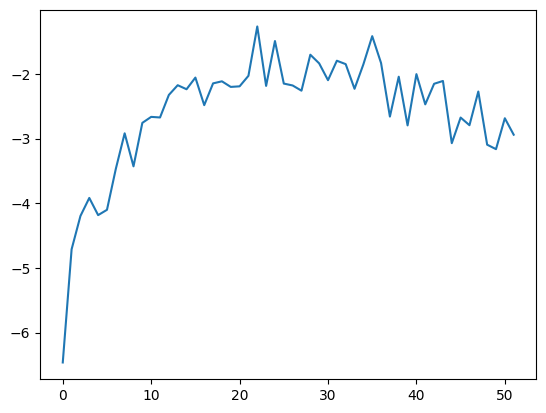

In [ ]:


plt.plot(optimal_scores[1:], label='DQN vs. Pseudo-Optimal')

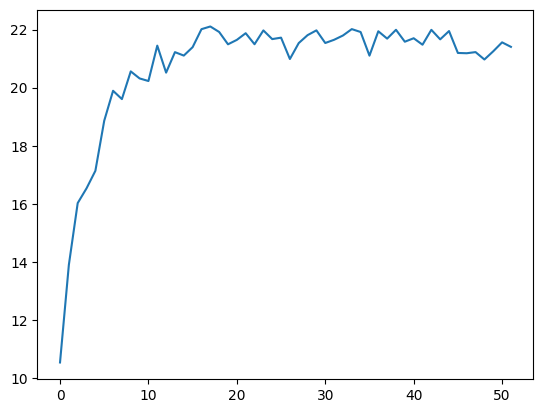

In [ ]:
plt.plot(baseline_scores[1:], label='DQN vs. Random')

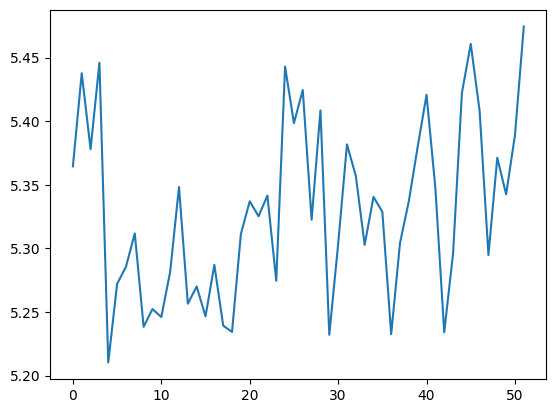

In [ ]:
plt.plot(optimal_turns[1:], label='DQN vs. Pseudo-Optimal Turns')